# Bond Yields and Selling Your Soul to the Devil
Kiran Ferrini

## Question 1: Bond Yields 
This problem uses information from Problem Set 4 (FRED).  
### Import the Weekly Economic Index from FRED.  

In [2]:
from fredapi import Fred
fred = Fred(api_key='91d55a1617750e1cc9dadb64d1e4c679')
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,5)
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import datetime


start = datetime.datetime(2008, 1, 5)
end = datetime.datetime(2023, 3, 13)

df_WEI = pdr.DataReader('WEI', 'fred', start, end)

x = df_WEI['WEI']
df_WEI

,WEI
DATE,
2008-01-05,1.68
2008-01-12,1.63
2008-01-19,1.60
2008-01-26,1.10
2008-02-02,0.79
...,...
2023-02-04,1.07
2023-02-11,0.94
2023-02-18,1.09


### Plot a histogram with 20 bins, and save the output.

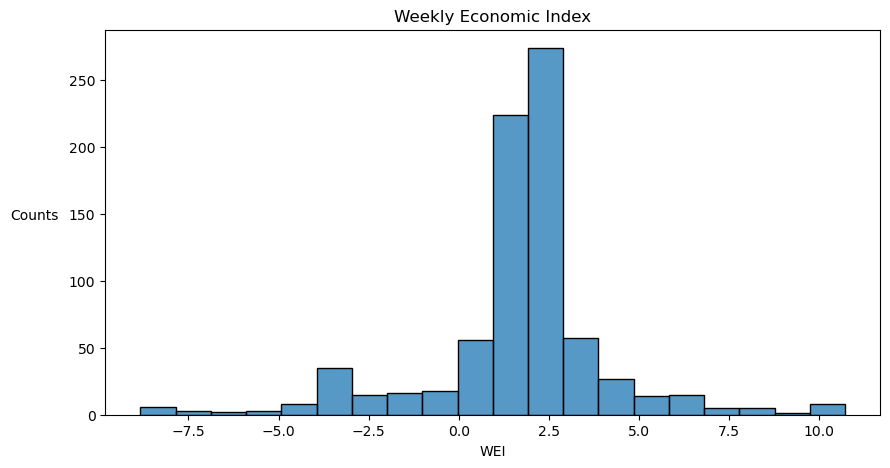

In [4]:
import seaborn as sns

n, bins, patches = plt.hist(x, bins = 20) #pull data from plot for markov matrix 
plt.close()
ax = sns.histplot(x, bins = 20)#Nicer looking plot - but harder to pull data from
ax.set(title = 'Weekly Economic Index')
ax.set_ylabel("Counts", rotation = 0, labelpad = 25);

### Group the data by mean growth rates within each bin. 

In [6]:
States = range(0,20)
def classify(x,bins,states):
    """
    x is the data
    bins gives the break points
    states are the names of the states
    """
    n = len(bins) # the number of edges of the bins is one more than the number of states
    conditions = []
    for i in range(n-1): # define an array of logical conditions
        conditions.append((x <= bins[i+1]) & (x >= bins[i]))
    return(np.select(conditions, states))

df_WEI['States'] = classify(x, bins, States)
gr = df_WEI.groupby('States').mean()
gr

,WEI
States,
0,-8.388333
1,-7.230000
2,-6.105000
3,-5.433333
4,-4.335000
5,-3.489429
6,-2.553333
7,-1.465000
8,-0.595556


### Estimate the Markov Matrix describing the transitions between states.

In [11]:
import quantecon as qe
from quantecon import MarkovChain

mm = qe.markov.estimate.estimate_mc(df_WEI['States'])

mm.P
pd.DataFrame(mm.P).style.background_gradient(axis=None, cmap='Greens')\
    .set_properties(**{'max-width': '420px', 'font-size': '12pt'})\
    .format(precision = 2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.83,0.17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.67,0.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.50,0.00,0.00,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.33,0.67,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.12,0.12,0.50,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.03,0.89,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.13,0.73,0.13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.62,0.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.11,0.56,0.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.05,0.69,0.22,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Use the Markov Matrix to estimate gross yields on 1 year and 30 year bonds for each state.
Use $\beta = 0.97$ and $\gamma = 2$ 

In [81]:
def u(c,γ):
    if γ == 1:
        return np.log(c) 
    return (c**(1-γ)-1)/(1-γ)

def kern(c0,c1,γ):
    """
    This function returns a vector of marginal rates of substitution 
    It's shape is 1 x n
    c0 is current consumption -- a scalar
    c1 is list of future consumptions
    γ is the inter-temporal elasticity of substitution
    """
    if γ == 1:
        return np.true_divide(1,c1)/(1/c0) 
    else: 
        return np.power(c1,-γ)/c0**(-γ)
    
def mkern(c,β,γ):
    """
    This method gets the matrix of Arrow security prices
    K(i,j) is the price of Arrow security j, when one is in state i
    """
    n = len(c) # number of states
    K = np.zeros((n,n)) # start with an array of zeros
    for i in range (n):
        K[i,:] = β*kern(c[i],c,γ)  # each row is an asset pricing kernel for consumption in state i
    return(K)



c = np.exp(gr/100)['WEI'] # Bond consumption payouts based on growth rates
beta = 0.97**(1/52) # Weekly discount factor
g = 2
M = mm.P
t = 52 #1 year 
K = mkern(c, beta, g)
R = np.full(20, 1.0)

def pricing_T(M,K,R,T):
    """
    M is a markov matrix
    K is a pricing kernel
    R is a matrix of asset payouts.
    R is an n x m matrix.  
    There are n states and m assets.
    R(:,j) is the description of asset j
    The asset returns are by column.
    R(i,j) is what asset j pays if state i happens.
    This method returns a n x m matrix P
    P(i,j) is the price of asset j in state i
    This method prices assets that pay out in the period T only
    
    I added better (in my opinion) error checking
    """
    if M.shape != K.shape:
        raise Exception('Markov matrix and pricing kernels are not conformable.')
    if M.shape[1] != R.shape[0]:
        raise Exception('Asset price matrix is not conformable.')
    M1 = np.multiply(M,K) #element-by-elemnt multiplication
    P = np.matmul(np.linalg.matrix_power(M1,T), R)  #raise M1 to the T the right multiply by R
    return(P)

### Gross Yields for 1 and 30 Years in Percents

In [89]:
dict = {"1 year" : (1/pricing_T(M, K, R, t) - 1)*100,
"30 years": ((1/pricing_T(M, K, R, t*30))**(1/30) - 1)*100} 

yields = pd.DataFrame.from_dict(dict)
yields.style.background_gradient(axis=None, cmap='RdYlGn')\
     .format(precision = 3)

,1 year,30 years
0,15.060,3.780
1,13.304,3.700
2,11.180,3.622
3,11.221,3.575
4,8.961,3.500
5,8.450,3.441
6,7.845,3.377
7,7.408,3.302
8,6.604,3.242
9,5.206,3.161


## Question 2: Deal with the Devil
Given this von Neumann-Morgenstern utility function:
\begin{align}
u(w) = \frac{1 - e^{\,w\cdot\gamma}}{\gamma}
\end{align}
Set $\gamma = \frac{1}{1000}$.

### Plot the utility function from 0 to 100,000.

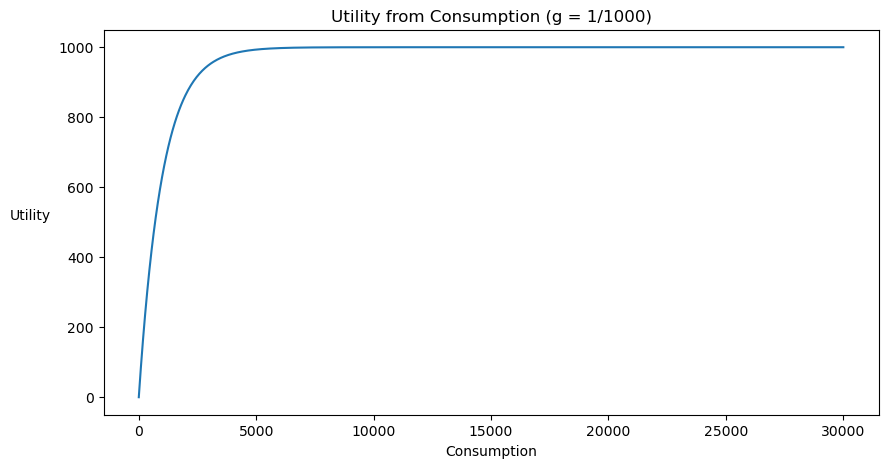

In [78]:
g = 1/1000

def u(c, g = g):
    if g == 1: 
        return 1 - np.exp(-c)
    return (1 - np.exp(-c*g))/g

x = np.linspace(0, 100_000, 1000)
y = u(x, g)
fig, ax = plt.subplots()
sns.lineplot(x=x, y=y, ax=ax)

ax.set_xlabel('Consumption')
ax.set_ylabel('Utility', rotation = 0, labelpad = 20)
ax.set_title('Utility from Consumption (g = 1/1000)')

plt.show()

## Show that you will not take a 50-50 gamble that loses \\$100 and wins \\$110.
Initial wealth is \\$30,000.

In [63]:
def eu(w, x, y, p, g = g): 
    return p*u(w-x, g) + (1-p)*u(w+y, g)

def ce(u, g = g):
    if g == 1:
        return -np.log(1 - u)
    return -np.log(1-g*u)/g

def takeit(w, lose, win, p, g = g):
    '''
    w is starting wealth
    lose is how much if lose
    win is how much if win
    p is pr of lose
    g is curvature (gamma)
    '''
    ceq = ce(eu(w, lose, win, p, g))
    if ceq == w:
        return print("The CE is equal to your starting wealth, you are indifferent to this deal.")
    if ceq > w:
        return print("The CE is greater than your starting wealth. You should take this deal. :-)", np.around(ceq, 3), 'vs ', w,)
    else:
        return print('The CE is less than your starting wealth. Do not touch this deal. >:-(', np.around(ceq, 3), 'vs',w)
                 

takeit(w = 30_000, lose = 100, win = 110, p = 0.5)

The CE is less than your starting wealth. Do not touch this deal. >:-( 29998.648 vs 30000


### The Devil Offers you all the wealth in the universe for a 50-50 gamble that could cost \\$1,000.
Initial wealth is still \\$30,000.

In [64]:
takeit(w = 30_000, lose = 1_000, win = float('inf'), p = 0.5)

The CE is less than your starting wealth. Do not touch this deal. >:-( 29693.641 vs 30000


### The Devil Offers you all the wealth in the universe for a 50-50 gamble that could cost \\$500.
Initial wealth is still \\$30,000.

In [65]:
takeit(w = 30_000, lose = 500, win = float('inf'), p = 0.5)

The CE is greater than your starting wealth. You should take this deal. :-) 30192.889 vs  30000
